In [1]:
import pandas as pd

import seaborn as sns
import numpy as np

# STEP 1: READING AND PROCESSING DATA
Dataset used: https://www.kaggle.com/datasets/atharvaingle/crop-recommendation-dataset

In [2]:
dataset = pd.read_csv("./data/crop.rec.csv")
dataset

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice
...,...,...,...,...,...,...,...,...
2195,107,34,32,26.774637,66.413269,6.780064,177.774507,coffee
2196,99,15,27,27.417112,56.636362,6.086922,127.924610,coffee
2197,118,33,30,24.131797,67.225123,6.362608,173.322839,coffee
2198,117,32,34,26.272418,52.127394,6.758793,127.175293,coffee


In [3]:
dataset.isna().sum().sum()

0

There are no null values!

In [4]:
labels_unique = list(set(dataset["label"]))
dataset["label"] = dataset["label"].map(lambda x: labels_unique.index(x))
dataset

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,11
1,85,58,41,21.770462,80.319644,7.038096,226.655537,11
2,60,55,44,23.004459,82.320763,7.840207,263.964248,11
3,74,35,40,26.491096,80.158363,6.980401,242.864034,11
4,78,42,42,20.130175,81.604873,7.628473,262.717340,11
...,...,...,...,...,...,...,...,...
2195,107,34,32,26.774637,66.413269,6.780064,177.774507,18
2196,99,15,27,27.417112,56.636362,6.086922,127.924610,18
2197,118,33,30,24.131797,67.225123,6.362608,173.322839,18
2198,117,32,34,26.272418,52.127394,6.758793,127.175293,18


In [5]:
train_dataset = dataset.sample(frac=0.8, random_state=42)
test_dataset = dataset.drop(train_dataset.index)

# STEP 2: FEATURE VISUALISATION/SELECTION

,count,mean,std,min,25%,50%,75%,max
N,1760.0,50.540341,36.779162,0.000000,21.000000,37.000000,84.000000,140.000000
P,1760.0,53.518182,33.252847,5.000000,28.000000,51.000000,68.000000,145.000000
K,1760.0,48.578977,51.173600,5.000000,20.000000,32.000000,49.000000,205.000000
temperature,1760.0,25.614251,5.077277,8.825675,22.780645,25.548603,28.636212,43.360515
humidity,1760.0,71.384936,22.405184,14.258040,60.231681,80.432472,90.015634,99.981876
ph,1760.0,6.464833,0.783890,3.504752,5.956308,6.422961,6.931730,9.935091
rainfall,1760.0,103.412477,55.220490,20.211267,64.509670,94.867624,124.704676,298.560117
label,1760.0,10.553977,6.309565,0.000000,5.000000,11.000000,16.000000,21.000000


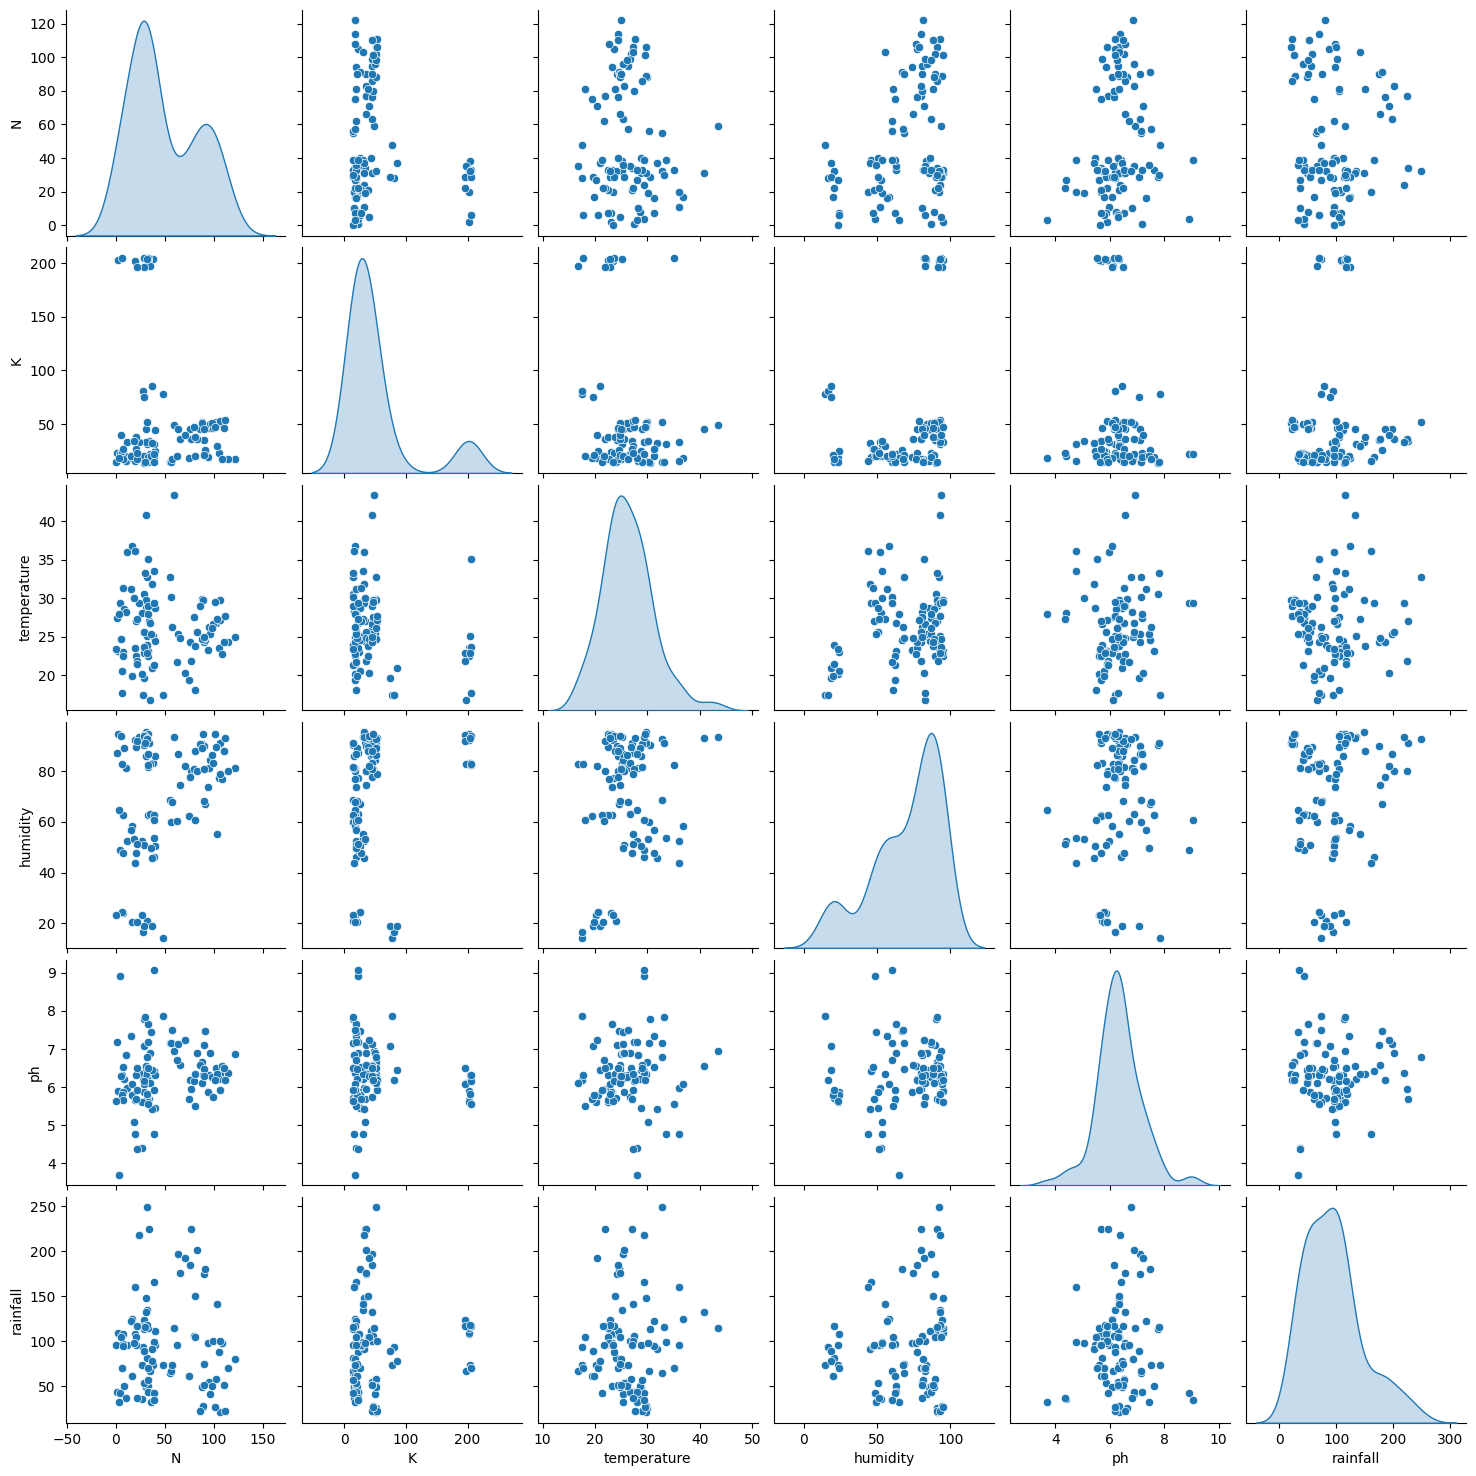

In [6]:
sns.pairplot(
    train_dataset[["N", "K", "temperature", "humidity", "ph", "rainfall"]].sample(
        n=100
    ),
    diag_kind="kde",
)
train_dataset.describe().transpose()

In [7]:
X_train = train_dataset.copy().drop("label", axis=1)
X_test = test_dataset.copy().drop("label", axis=1)

In [8]:
Y_train = train_dataset.copy()["label"]
Y_test = test_dataset.copy()["label"]

## Normalizing the Data

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train

array([[ 1.37235321, -1.09850929, -0.03086408, ...,  1.04223706,
        -0.35701274, -1.39669499],
       [ 1.2907621 , -1.36923973,  0.04732344, ...,  0.6758234 ,
        -0.26222418, -0.97784915],
       [ 0.23007766,  0.25514293,  0.00822968, ...,  0.98072055,
         0.60824815,  0.20588053],
       ...,
       [ 2.18826431,  0.19498061, -0.61727047, ...,  0.46474879,
         1.2252758 , -0.36133002],
       [ 2.05227913, -0.46680492, -0.49998919, ...,  0.54680677,
        -0.36765094, -0.27128597],
       [ 1.31795913, -1.03834697, -0.3045204 , ..., -0.70843937,
        -0.24384134,  0.49316793]])

# STEP 3: MODEL SELECTION

In [68]:
### INITIALIZATION ###

from sklearn.metrics import multilabel_confusion_matrix
import time


def run_model(m, fit = True):
    begin = time.time()

    ret = {}
    if fit:
        m.fit(X_train, Y_train)
    ret["cnf"] = multilabel_confusion_matrix(Y_test, m.predict(X_test))
    ret["score"] = m.score(X_test, Y_test)
    ret["time"] = time.time() - begin

    return ret

# 3.1 TESTING VARIOUS CLASSIFICATION MODELS

In [66]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

clf_models = [
    SVC(),
    KNeighborsClassifier(),
    RandomForestClassifier(random_state=42),
    DecisionTreeClassifier(random_state=42),
]

for model in clf_models:
    print(f"> testing model: {model.__class__.__name__}")
    scores = run_model(model)
    print(f"  accuracy:   {(scores['score'] * 100):.{3}}%")
    print(f"  time taken: {scores['time']:.{3}}s")
    print("  confusion matrix:")
    print(scores["cnf"].sum(axis=0))

> testing model: SVC
  accuracy:   99.3%
  time taken: 0.076s
  confusion matrix:
[[9237    3]
 [   3  437]]
> testing model: KNeighborsClassifier
  accuracy:   99.1%
  time taken: 0.0331s
  confusion matrix:
[[9236    4]
 [   4  436]]
> testing model: RandomForestClassifier
  accuracy:   99.8%
  time taken: 0.287s
  confusion matrix:
[[9239    1]
 [   1  439]]
> testing model: DecisionTreeClassifier
  accuracy:   98.4%
  time taken: 0.0104s
  confusion matrix:
[[9233    7]
 [   7  433]]


In [67]:
from joblib import dump, load

dump(clf_models[2], "./out/crop.recommend.joblib")

['./out/crop.recommend.joblib']

In [70]:
clf = load("./out/crop.recommend.joblib")

scores = run_model(clf, False)
print(f"  accuracy:   {(scores['score'] * 100):.{3}}%")
print(f"  time taken: {scores['time']:.{3}}s")
print("  confusion matrix:")
print(scores["cnf"].sum(axis=0))

  accuracy:   99.8%
  time taken: 0.0293s
  confusion matrix:
[[9239    1]
 [   1  439]]
